In [1]:
__author__ = 'Chien-Hsiu Lee <lee@noao.edu>, Knut Olsen <kolsen@noao.edu>'
__version__ = '20210111' # yyyymmdd
__datasets__ = ['']
__keywords__ = ['ANTARES', 'variable', 'AAS237']

# Exploring ANTARES Alert Database for Variable Stars

*Chien-Hsiu Lee, Knut Olsen & Data Lab and ANTARES Team*

### Table of contents
* [Goals & notebook summary](#goals)
* [Disclaimer & Attribution](#attribution)
* [Imports & setup](#import)
* [Querying ANTARES alert database ](#query)
* [Inspecting light curves](#lightcurve)
* [Resources and references](#resources)

<a class="anchor" id="goals"></a>
# Goals
This notebook is an example of how to explore the ANTARES alert database for variable stars. Here we search the ZTF time-series photometry to see if there are variables in a dwarf galaxy, and perform further analysis of the variable light curves.

# Summary
We first identify and obtain the dwarf galaxy coordinates from DES. We then use the ANTARES search API to find time-series photometry of objects in the dwarf galaxy. We then show how to inspect the light curves, and find their periods. In the end, we also demonstrate how to trigger subsequent follow up with AEON using the TOMtoolkit interface.

# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: http://datalab.noao.edu/disclaimers.php

<a class="anchor" id="import"></a>
# Imports and setup

In [2]:
#from antares_client.search import search
import antares_client
import matplotlib.pyplot as plt
import pandas as pd

/data0/sw/antares-kernel-0.4/lib/python3.7/site-packages/scipy/__init__.py:140: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.16.4)
  UserWarning)


<a class="anchor" id="query"></a>
# Querying ANTARES alert database 

This cell shows how to call elastic search with ANTARES API (the antares_client we imported earlier). It can search on ZTF object id, RA, Dec, or other properties. For our purpose, we search for varying sources in the Ursa Minor dwarf galaxy (RA = 227.285 degree, DEC = 67.222 degree), with a search radius of 0.25 degrees.
In ANTARES we aggregrate alerts on the same point of sky to form a locus object (which we shall call it "locus" hereafter). If there is a match at the given position, the search will return the corresponding locus. An astropy.TimeSeries of all Alert Properties on this locus can be obtained using locus.timeseries. We can convert it to Panda dataframe using locus.timeseries.to_pandas() for futher analysis. Details of the locus object can be found in the ANTARES documentation at: https://noao.gitlab.io/antares/filter-documentation/devkit/locus.html

In [4]:
import antares_client
from astropy.coordinates import Angle, SkyCoord
center = SkyCoord("227.285d 67.222d")
radius = Angle("0.25d")

locusid=[]
locus_gr=[]
locus_r=[]
print("#Locus, RA, Dec, Num_alerts")
for locus in antares_client.search.cone_search(center, radius):
    if locus.properties['num_mag_values'] > 30:
        print("https://antares.noirlab.edu/loci/lookup/%s" % (locus.properties['ztf_object_id']), locus.ra, locus.dec, locus.properties['num_mag_values'], locus.alerts[-1].properties['ztf_sgmag1'] - locus.alerts[-1].properties['ztf_srmag1'], locus.alerts[-1].properties['ztf_srmag1'])
        locusid.append(locus.properties['ztf_object_id'])
        locus_gr.append(locus.alerts[-1].properties['ztf_sgmag1'] - locus.alerts[-1].properties['ztf_srmag1'])
        locus_r.append(locus.alerts[-1].properties['ztf_srmag1'])


#Locus, RA, Dec, Num_alerts
https://antares.noirlab.edu/loci/lookup/ZTF18aapnpxp 227.4650415090125 67.23184959776788 45 -0.10289955139160156 20.20050048828125
https://antares.noirlab.edu/loci/lookup/ZTF18aavahko 227.26304767490103 67.1691137945075 37 0.028499603271484375 19.338899612426758
https://antares.noirlab.edu/loci/lookup/ZTF18aaqmbqs 227.3569277820102 67.203745733418 74 0.2775993347167969 19.85300064086914
https://antares.noirlab.edu/loci/lookup/ZTF18aaqowgh 227.3502061211087 67.10099379691194 98 0.6824989318847656 19.342100143432617
https://antares.noirlab.edu/loci/lookup/ZTF18aapscwd 227.6100967449605 67.124552552642 41 0.796600341796875 19.395099639892578
https://antares.noirlab.edu/loci/lookup/ZTF18aaqmvlf 226.96067721846745 67.15751626751334 44 -0.5004005432128906 19.963300704956055
https://antares.noirlab.edu/loci/lookup/ZTF18aaoexnp 227.3073308554661 67.25926222542068 376 1.073699951171875 15.774299621582031
https://antares.noirlab.edu/loci/lookup/ZTF18aapmlzb 227.584366

<a class="anchor" id="cmd"></a>
# Inspecting CMDs

Looks like we got several candidates. Let's check where they are on the CMD. This can be done using the catalog holdings at DataLab.

In [5]:
ra0 = 227.285
dec0 = 67.222
radius = 0.25
columns = 'ra,dec,g_r,mag_r'

sql = '''
    SELECT {0} FROM ls_dr8.tractor_n
    WHERE Q3C_RADIAL_QUERY(ra,dec,{1},{2},{3})
    AND mag_r != 'nan' AND mag_r != 'Infinity'
'''.format(columns,ra0,dec0,radius)

In [6]:
import requests
import json
from dl import queryClient as qc
df0 = qc.query(sql=sql,fmt='pandas')

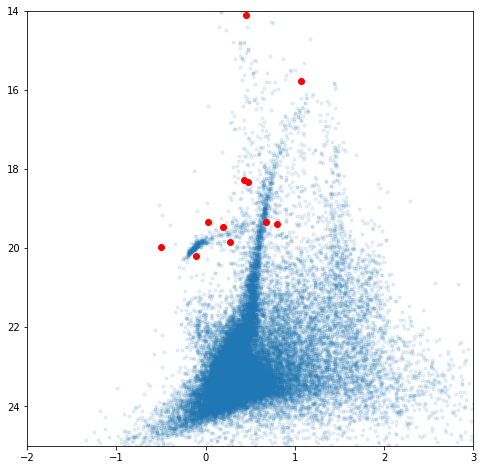

In [7]:
plt.figure(figsize=(8,8))
plt.xlim(-2,3)
plt.ylim(25,14)
plt.scatter(df0['g_r'],df0['mag_r'],marker='.',alpha=0.1)
#plt.scatter(dfhb0['g_r'],dfhb0['mag_r'],marker='.')
plt.scatter(locus_gr, locus_r,c='r')

<a class="anchor" id="lightcurve"></a>
# Inspecting light curves

Let's have a look at the light curves as well. This can be done using the ANTARES web portal, or by pulling out the light curves using antares_client as follows. 

/data0/sw/antares-kernel-0.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: TableReplaceWarning: converted column 'ztf_candid' from integer to float
  This is separate from the ipykernel package so we can avoid doing imports until
/data0/sw/antares-kernel-0.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: TableReplaceWarning: converted column 'ztf_field' from integer to float
  This is separate from the ipykernel package so we can avoid doing imports until
/data0/sw/antares-kernel-0.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: TableReplaceWarning: converted column 'ztf_nbad' from integer to float
  This is separate from the ipykernel package so we can avoid doing imports until
/data0/sw/antares-kernel-0.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: TableReplaceWarning: converted column 'ztf_ncovhist' from integer to float
  This is separate from the ipykernel package so we can avoid doing imports until
/data0/sw/antares-kernel-0.4/lib/python3.7/site-packa

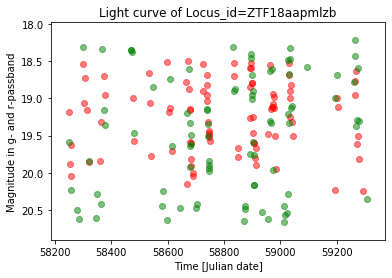

In [8]:
locus = antares_client.search.get_by_ztf_object_id("ZTF18aapmlzb")
#locus = antares_client.search.get_by_id("ANT2020bgjoo")
df = locus.timeseries.to_pandas()
df = df[['ant_mjd', 'ztf_fid', 'ztf_magpsf', 'ztf_sigmapsf']]
dn = df.dropna()

plt.ylim(max(dn['ztf_magpsf'])+0.1*(max(dn['ztf_magpsf'])-min(dn['ztf_magpsf'])),min(dn['ztf_magpsf'])-0.1*(max(dn['ztf_magpsf'])-min(dn['ztf_magpsf'])))
plt.scatter(dn['ant_mjd'][dn['ztf_fid']==2], dn['ztf_magpsf'][dn['ztf_fid']==2], c='red', alpha=0.5)
plt.scatter(dn['ant_mjd'][dn['ztf_fid']==1], dn['ztf_magpsf'][dn['ztf_fid']==1], c='green', alpha=0.5)
plt.title('Light curve of Locus_id=ZTF18aapmlzb')
plt.xlabel('Time [Julian date]')
plt.ylabel('Magnitude in g- and r-passband')
plt.show()

In [9]:
from astropy import stats
import numpy as np
def get_ls_periodogram(t,y,min_freq=1./1.,max_freq=1./0.1):
    
    """Compute Lomb-Scargle periodogram.
    
    Parameters
    ----------
    t : array
        Observation time array (e.g. MJD), ordered in ascending order.
    
    y : array
        Magnitude measurements at times ``t``.
        
    min_freq, max_freq : float or None
        The period finder can be guided by providing the min and max frequency
        in the ``y`` signal, in units 1/t. 
          min_freq = 1/longest expected period (in days)
          max_freq = 1/shortest expected perdiod (in days)
        The defaults are typical for RR Lyrae variability (RR Lyrae usually
        have a period of a fraction of one day).
        
    Returns
    -------
    period : array
        Phased period of the time-variable signal (fraction of the phase).
        
    power : array
        The periodogramm power as function if ``period``.
        
    """
    
    # Use astropy's LombScargle class
    ls = stats.LombScargle(t, y)

    # Compute the periodogram
    #   We guide the algorithm a bit:
    #     min_freq = 1/longest expected period (in days)
    #     max_freq = 1/shortest expected perdiod (in days)
    #   RR Lyrae usually have a period of a fraction of one day
    frequency, power = ls.autopower(minimum_frequency=min_freq,maximum_frequency=max_freq)
    period = 1./frequency # period is the inverse of frequency
    
    return period, power


def get_best_period(period,power):
    
    """Return the period with highest power."""
    
    return period[np.argmax(power)]

def plot_periodogram(period,power,best_period=None,title='',ax=None):

    """Plot a periodogram.
    
    Parameters
    ----------
    
    period, power : array
        The period and power 1-d arrays as returned by :func:`get_ls_periodogram()`
    
    best_period : float or None
        If float, the value of this ``best_period`` will be marked in the plot.
    
    title : str
        Title of the figure. Default: ''.
    
    ax : instance or None
        If instance of axis class, will plot to that object. If None, will generate a new figure and axis object.
    """
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,7))
        
    ax.plot(period,power,lw=0.8)
    ax.set_xlabel('period (days)')
    ax.set_ylabel('relative power')
    ax.set_title(title)
    
    if best_period is not None:
        ax.axvline(best_period,color='r',lw=0.5);
        ax.text(0.03,0.93,'period = {:.3f} days'.format(best_period),transform=ax.transAxes,color='r')
        
def get_folded_phase(t,best_period):
    
    """Fold the observation times with the best period of the variable signal."""
    
    # light curve over period, take the remainder (i.e. the "phase" of one period)
    phase = (t / best_period) % 1
    
    return phase

def plot_folded_lightcurve(t,y,best_period,dy=None,ax=None):
    
    """Plot folded lightcurve.
    
    Parameters
    ----------
    
    t, y : array
        Time and magnitude 1-d arrays
        
    best_period : float
        True period of the signal.
        
    dy : array or None
        If array, the values are the uncertainies on ``y``, and the plot will show errorbars.
        If None, the plot will have no errorbars.
        
    ax : instance or None
        If instance of axis class, will plot to that object. If None, will generate a new figure and axis object.
    """

    phase = get_folded_phase(t,best_period)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,7))
        
    marker = '.'
    ms = 10
    lw = 1
    color = 'r'
    alpha = 0.6    
    
    if dy is not None:
        ax.errorbar(phase,y,yerr=dy,marker=marker,ms=ms,ls='none',lw=lw,color=color,alpha=alpha)
    else:
        ax.plot(phase,y,marker=marker,ms=ms,ls='none',lw=lw,color=color,alpha=alpha)
            
    ax.set_title('phased lightcurve')
    ax.invert_yaxis()
    ax.set_xlabel('phase (days)')
    ax.set_ylabel('magnitude');

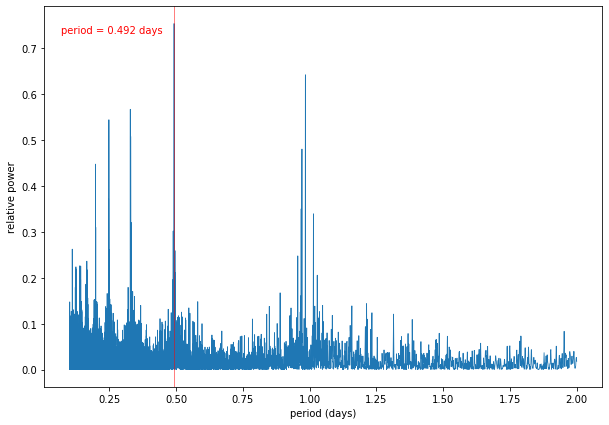

In [10]:
t=dn['ant_mjd'][dn['ztf_fid']==2]
m=dn['ztf_magpsf'][dn['ztf_fid']==2]
period, power = get_ls_periodogram(t,m,min_freq=1./2.,max_freq=1./0.1)
best_period = get_best_period(period,power)
plot_periodogram(period,power,best_period,title='')

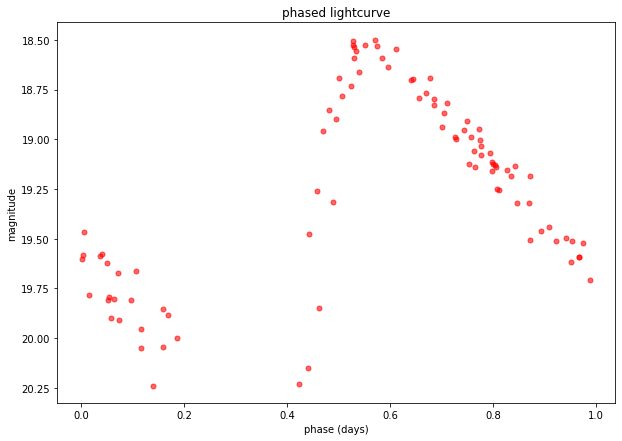

In [11]:
plot_folded_lightcurve(t,m,best_period)

# Concluding remarks

ZTF18aapmlzb appears to be a RR Lyrae with a period of 0.492 day. We can trigger further follow up with telescope resources by AEON (including Gemini).